# set up

Traceback (most recent call last):
  File "/home/joshua/Projects/ID-disentanglement-Pytorch/Utils/data_creator.py", line 1, in <module>
    from Models.StyleGan2.model import Generator
ModuleNotFoundError: No module named 'Models'


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install facenet_pytorch
# !pip install lpips
# !pip install pytorch-msssim
# !pip install wandb

In [1]:
import os

In [8]:
# !git clone https://github.com/danielroich/Face-Identity-Disentanglement-via-StyleGan2.git 'project'
CODE_DIR = '/home/joshua/Projects/ID-disentanglement-Pytorch'
os.chdir(f'{CODE_DIR}')

In [9]:
BASE_PATH = '/home/joshua/Projects/ID-disentanglement-Pytorch/'

In [32]:
from Models.StyleGan2.model import Generator
from pathlib import Path
from torchvision import utils
from tqdm import tqdm
import torch.utils.data
import numpy as np
from Configs import Global_Config

MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

generator = Generator(256, 512, 8).eval().cuda()
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

NUMBER_OF_IMAGES = 100

with torch.no_grad():
    mean_latent = generator.mean_latent(4096 * 100)

counter = 0
cur_dir = 0
num_of_images_in_single_loop = 1
latents_total = []
for i in tqdm(range(NUMBER_OF_IMAGES // num_of_images_in_single_loop)):
    with torch.no_grad():
        sample_z = torch.randn(num_of_images_in_single_loop, 512, device='cuda')
        sample, latents = generator(
            [sample_z], input_is_latent=False, return_latents=True, truncation=0.5, truncation_latent=mean_latent
        )

    for index in range(len(sample)):
        if (counter % 1000) == 0:
            Path(f"{W_DATA_DIR}{int(counter / 1000)}").mkdir(parents=True, exist_ok=True)
            Path(f"{IMAGE_DATA_DIR}{int(counter / 1000)}").mkdir(parents=True, exist_ok=True)
            cur_dir = int(counter / 1000)

        with open(f'{W_DATA_DIR}{cur_dir}/{counter}.npy', 'wb') as f:
            np.save(f, latents.cpu()[index][0])

        utils.save_image(
            sample[index],
            f'{IMAGE_DATA_DIR}{cur_dir}/{counter}.png',
            nrow=1,
            normalize=True,
            range=(-1, 1)
        )

        counter += 1

  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.49it/s]


In [10]:
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

In [11]:
from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

  0%|          | 0.00/107M [00:00<?, ?B/s]

# network

In [12]:
id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)
attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616315604.9508004_0.pt')
attr_encoder = Inception(attr_encoder)
discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE, 512, 8)

Loading ResNet ArcFace


In [14]:
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

_IncompatibleKeys(missing_keys=['noises.noise_0', 'noises.noise_1', 'noises.noise_2', 'noises.noise_3', 'noises.noise_4', 'noises.noise_5', 'noises.noise_6', 'noises.noise_7', 'noises.noise_8', 'noises.noise_9', 'noises.noise_10', 'noises.noise_11', 'noises.noise_12'], unexpected_keys=[])

In [15]:
# load our checkpoints

mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616315604.542634_0.pt')

In [16]:
id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
generator = generator.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

In [17]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.eval()
generator = generator.eval()
mlp = mlp.eval()
landmark_encoder = landmark_encoder.eval()

# get images

In [18]:
w_image_dataset = Image_W_Dataset(W_DATA_DIR, IMAGE_DATA_DIR)
data_loader = DataLoader(dataset=w_image_dataset, batch_size=config['batchSize'], shuffle=False)

In [33]:
data = next(iter(data_loader))

In [34]:
ws, images = data

In [35]:
import matplotlib.pyplot as plt

In [36]:
plot_images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [37]:
# choose idx 
id_idx = 5

In [38]:
attr_idx = (config['batchSize']-1) if id_idx==0 else (id_idx - 1)

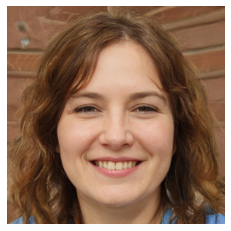

In [39]:
# identity

plt.axis('off')
plt.imshow(plot_images[id_idx])
plt.show()

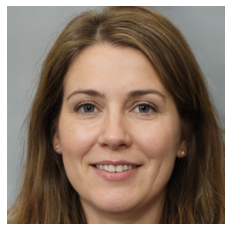

In [40]:
# attribute

plt.axis('off')
plt.imshow(plot_images[attr_idx])
plt.show()

# have fun!

In [41]:
test_ws = ws.to(Global_Config.device)
test_id_images = images.to(Global_Config.device)
test_attr_images_cycled = cycle_images_to_create_diff_order(test_id_images)

In [42]:
def get_concat_vec(id_images, attr_images, id_encoder, attr_encoder):
    with torch.no_grad():
        id_vec = torch.squeeze(id_encoder.extract_feats((id_images * 2) - 1))
        attr_vec = torch.squeeze(attr_encoder(attr_images))
        test_vec = torch.cat((id_vec, attr_vec), dim=1)
        return test_vec

In [43]:
concat_vec_cycled = get_concat_vec(test_id_images, test_attr_images_cycled, id_encoder, attr_encoder)

In [44]:
with torch.no_grad():
  mapped_concat_vec_cycled = mlp(concat_vec_cycled)

In [45]:
with torch.no_grad():
  cycled_generated_image = get_w_image(mapped_concat_vec_cycled[id_idx], generator)

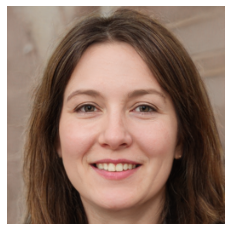

In [46]:
# Result!

plt.axis('off')
plt.imshow(cycled_generated_image)
plt.show()